# Avaliação - Parte Prática

# Pedro Buczinski Lages de Carvalho - 12555266

$MSE$ direção: $1,62$       
$MSE$ velocidade: $159,50$ \\
$R^2$ direção: $0,93$  
$R^2$ velocidade: $0,98$


## 1. Carregamento e Pré-processamento

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

try:
  X_train = pd.read_csv('X_train.csv').to_numpy()
  y_train = pd.read_csv('y_train.csv').to_numpy()
  X_test = pd.read_csv('X_test.csv').to_numpy()
  y_test = pd.read_csv('y_test.csv').to_numpy()
except:
  X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/X_train.csv").to_numpy()
  y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/y_train.csv").to_numpy()
  X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/X_test.csv").to_numpy()
  y_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PSI3471/Parte 1/EP Prova/y_test.csv").to_numpy()


# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (95% da variância explicada)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled) #o X_test mantém todos os exemplos originais, apenas representados num novo espaço dimensional consistente com o modelo treinado.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train_pca.shape

(19628, 9)

In [ ]:
y_train.shape

(19628, 2)

In [ ]:
X_test_pca.shape

(4907, 9)

In [ ]:
y_test.shape

(4907, 2)

## 2. Definição do Modelo

In [ ]:
# Ajuste de hiperparâmetros

# passo de adaptação da rede MLP
eta = 0.005

# Tamanho do mini-batch
Nb = 200

# Número de épocas
Ne = 2000

In [ ]:
class Model(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.model(x)

def weights_init_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu', a=0.01)
        nn.init.zeros_(m.bias)


## 3. Treinamento com Validação

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_set = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_set, batch_size=Nb, shuffle=True)

model = Model(input_size = X_train_pca.shape[1]).to(device)
model.apply(weights_init_he)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

train_losses, test_losses = [], []
best_test_loss = float('inf')
best_model_state = None

for epoch in range(Ne):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_function(pred, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor.to(device))
        test_loss = loss_function(test_pred, y_test_tensor.to(device)).item()

    train_losses.append(loss.item())
    test_losses.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_state = model.state_dict()


    if epoch % 100 == 0:
        print(f"Época {epoch} | Loss de treino: {loss.item():.4f} |  Loss de validação: {test_loss:.4f}")

Época 0 | Loss de treino: 3658.6685 |  Loss de validação: 3442.1165
Época 100 | Loss de treino: 87.2603 |  Loss de validação: 136.9504
Época 200 | Loss de treino: 40.5715 |  Loss de validação: 102.1233
Época 300 | Loss de treino: 36.9275 |  Loss de validação: 85.1849
Época 400 | Loss de treino: 20.6583 |  Loss de validação: 82.7480
Época 500 | Loss de treino: 48.1322 |  Loss de validação: 86.6926
Época 600 | Loss de treino: 115.8967 |  Loss de validação: 90.9606
Época 700 | Loss de treino: 40.6474 |  Loss de validação: 70.9694
Época 800 | Loss de treino: 36.1793 |  Loss de validação: 83.4930
Época 900 | Loss de treino: 8.9265 |  Loss de validação: 76.5031
Época 1000 | Loss de treino: 11.1124 |  Loss de validação: 82.9093
Época 1100 | Loss de treino: 25.4416 |  Loss de validação: 77.3072
Época 1200 | Loss de treino: 16.7102 |  Loss de validação: 81.0334
Época 1300 | Loss de treino: 11.7491 |  Loss de validação: 73.9481
Época 1400 | Loss de treino: 13.7172 |  Loss de validação: 86.5644
É

## 4. Avaliação Final

In [ ]:
torch.save(best_model_state,  "./model01.pt")
model.load_state_dict(torch.load( "./model01.pt"))
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).cpu().numpy()

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"MSE direção: {mse[0]:.4f}, MSE velocidade: {mse[1]:.4f}")
print(f"R² direção: {r2[0]:.4f}, R² velocidade: {r2[1]:.4f}")

MSE direção: 1.6189, MSE velocidade: 159.5073
R² direção: 0.9297, R² velocidade: 0.9829


## 5. Curvas de Aprendizado

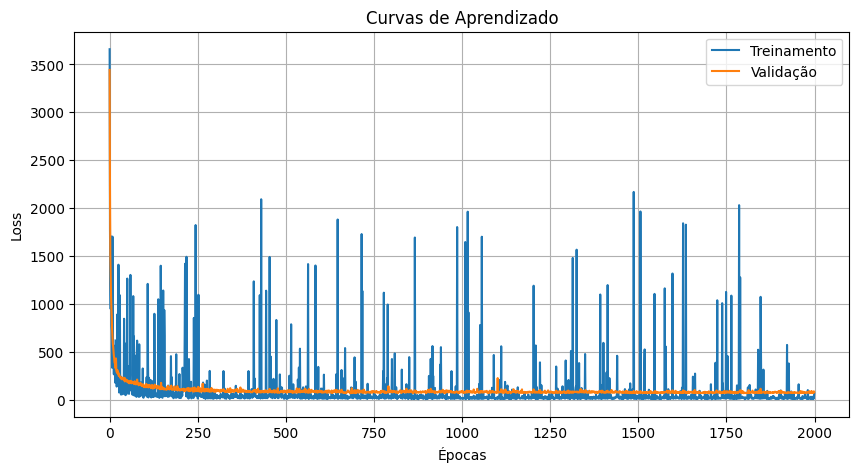

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Treinamento")
plt.plot(test_losses, label="Validação")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curvas de Aprendizado")
plt.legend()
plt.grid(True)
plt.show()